# [Module 1.1] Personalize Data File 준비

이 노트북은 아래와 같은 작업을 합니다.
- MovieLens 데이타를 다운로드
- 데이터 형태 및 전체 인터렉션 분포 확인
- 데이터 준비
    - 인터렉션 데이타를 유니크한 아이템 기준으로 학습/검증(50%) 데이터 셋 및 신상품 검증을 위한 ColdStart(50%) 데이터 셋 분리
    - 위에서 분리한 학습/검증 데이터 셋을 90%, 10%로 분리하여, 학습 후에 검증 데이터 셋으로 모델 검증을 합니다.
- 준비된 데이터를 로컬 저장 및 S3에 업로드

---
이 노트북을 모두 실행하는데 걸리는 시간은 약 3분 소요 됩니다.



#### Notebook 사용법

코드는 여러 코드 셀들로 구성됩니다. 이 페이지의 상단에 삼각형으로 된 실행 단추를 마우스로 클릭하여 각 셀을 실행하고 다음 셀로 이동할 수 있습니다. 또는 셀에서 키보드 단축키 `Shift + Enter`를 눌러 셀을 실행하고 다음 셀로 이동할 수도 있습니다.

셀이 실행되면 셀이 실행되는 동안 측면에 줄이 * 표시되어 있거나 셀 내의 모든 코드를 예측한 후 실행이 완료된 마지막 셀을 나타내기 위해 숫자로 업데이트됩니다.

아래 지침을 따르고 셀을 실행하여 Amazon Personalize를 시작하세요.

#### Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# import matplotlib.dates as mdate
# from botocore.exceptions import ClientError

## MovieLens 데이터를 다운로드 받습니다. 

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록

#### 중요 하이퍼 파라미터
**min_user_history_length_percentile, max_user_history_length_percentile**
- 일반적으로 가지고 있는 interaction의 데이타 셋이 사용자당 interaction의 수가 다릅니다.
즉 1개인 사용자도 많고, 엄청 많은 사용자도 있습니다. **이런 양 극단의 사용자를 제외하고 학습 데이타로 사용하는 것이 더욱 의미있는 추천을 받을 수 있습니다.** 아래 예 및 링크를 참고하시기 바랍니다.
    - For example, setting min_user_history_length_percentile to 0.05 and max_user_history_length_percentile to 0.95 includes all users except those with history lengths at the bottom or top 5%.


- User-Personalization Recipe
    - https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-new-item-USER_PERSONALIZATION.html

### 데이터 세트 다운로드 및 로딩

In [44]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip
df_all = pd.read_csv('./ml-1m/ratings.dat',sep='::',names=['USER_ID','ITEM_ID','EVENT_VALUE', 'TIMESTAMP'])
df_all['EVENT_TYPE']='RATING'
items_all = pd.read_csv('./ml-1m/movies.dat',sep='::', encoding='latin1',names=['ITEM_ID', '_TITLE', 'GENRE'])
del items_all['_TITLE']
pd.set_option('display.max_rows', 5)

--2021-08-31 15:48:38--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ml-1m.zip’ not modified on server. Omitting download.

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


## 데이타 형태 확인하기

데이터를 한번 확인해 봅니다.

In [45]:
items = items_all.copy()
items

,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


In [46]:
df = df_all.copy()
df

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
1,1,661,3,978302109,RATING
...,...,...,...,...,...
1000207,6040,1096,4,956715648,RATING
1000208,6040,1097,4,956715569,RATING


유니크한 유저는 6040명, 유니크한 영화인 아이템은 3706, 이벤트 타입은 rating으로서 1개가 존재 합니다.

In [47]:
# 컬럼별 유니크 갯수
df.nunique()

USER_ID          6040
ITEM_ID          3706
EVENT_VALUE         5
TIMESTAMP      458455
EVENT_TYPE          1
dtype: int64

### 전체 Interaction 분포

Interaction 분포는 아래와 같습니다. <br>
**유저에 대해서 최소는 20번이고, 중간값은 96번, 최대는 2314번을 rating을 했습니다.**

In [53]:
pd.options.display.max_rows = 10
user_activity_counts = df.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
user_activity_counts.describe()

,INTERACTION_COUNTS
count,6040.000000
mean,165.597517
std,192.747029
min,20.000000
25%,44.000000
50%,96.000000
75%,208.000000
max,2314.000000


### 인터렉션 숫자당 유저 수

인터렉션이 20번, 21번이 86명, 91명이 숫자를 보이고 있고, 1850번, 2314번이 1명, 1명의 분포를 보이고 있습니다.

In [57]:
user_interaction_counts=user_activity_counts.reset_index()
activities = user_interaction_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities

,NUM_USERS
INTERACTION_COUNTS,
20,86
21,91
22,77
23,81
24,81
...,...
1521,1
1595,1
1743,1


인터렉션이 최소인 20번에서 75번까지의 유저수의 분포를 확인 합니다.

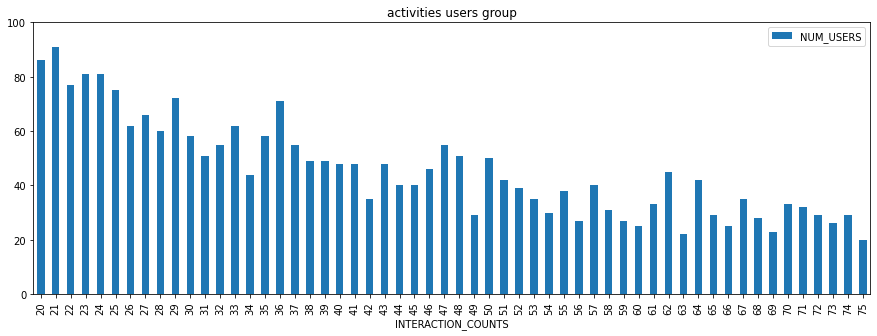

In [69]:
num_interactions = 75
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,100))
plt.title("activities users group")

plt.show()

인터렉션이 최소인 20번에서 최대인 2314번까지의 유저수의 분포를 확인 합니다.<br>
분포가 점점 감소하는 것을 확인할 수 있습니다.

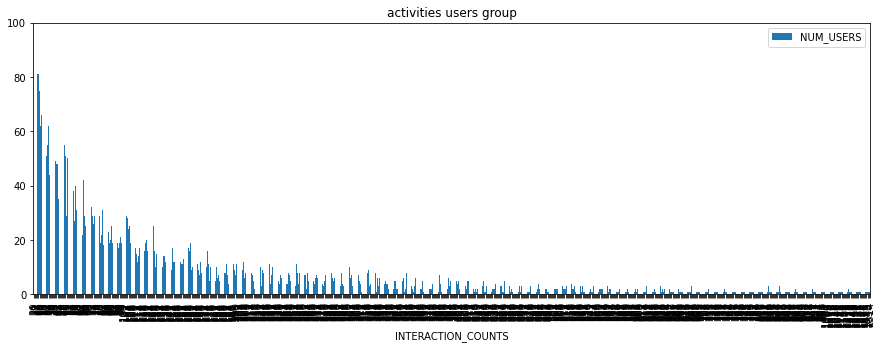

In [71]:
num_interactions = 2314
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,100))
plt.title("activities users group")

plt.show()

##  데이터 분리

이 데이터에는 UserID, ItemID, Rating 및 Timestamp 컬럼이 포함되어 있습니다.<br>

- (1) Cold Start item 테스트를 위해 고유한 아이템 50% 에대한 interaction 데이터를 분리합니다. 
    - Coldstart 테스트 용으로는 더 적은 데이터만 남기셔도 됩니다. 
         이번 Lab에서는 Training 시간 단축을 위해 50%정도 데이터만 학습에 사용합니다. 
- (2) 모델 완성 후 성능 검증하기 위해 나머지 50% 데이타를 다음과 같이 분리 합니다.
    - 시간순으로 정렬한 후에 90%는 학습용 데이터로, 마지막 최근 10% 데이터를 검증용 데이터로 분리합니다.

![img_datasplit50_v1](static/imgs/img_datasplit50_v1.png)


## (1) 인터렉션 데이타를 Warm Data(Training, Validation Data, 50%),  ColdStart Data (50%) 분리

unique items을 구한 후에 랜덤하게 정렬 합니다. <br>
이후에 warm_items, cold_items를 50%, 50% 씩 나눕니다.

In [77]:
# Create list of unique items
unique_items = df['ITEM_ID'].unique()
unique_items = np.random.RandomState(seed=42).permutation(unique_items)
print("# of Unique Items: ", len(unique_items))

# of Unique Items:  3706


In [78]:
warm_items = unique_items[len(unique_items)//2:]
cold_items = unique_items[:len(unique_items)//2]
print("The number of Warm_items: {}".format(len(warm_items)))
print("The number of Cold_items: {}".format(len(cold_items)))

The number of Warm_items: 1853
The number of Cold_items: 1853


warm, cold (ColdStart) 에 속하는 item_id를 확인 합니다.

In [79]:
pd.options.display.max_rows = 5
item_tb = pd.DataFrame(data={'warm':np.sort(warm_items), 'cold':np.sort(cold_items)})
item_tb

,warm,cold
0,1,2
1,3,4
...,...,...
1851,3949,3950
1852,3951,3952


#### Warm Data Set 정보
유니크 아이템의 50% 인 warm_items로 구성된 데이터 입니다.

In [80]:
def split_dataset(df, distinct_items):
    split_df = df.copy()
    #Create Training data with only Warm-item
    split_df['to_keep'] = split_df['ITEM_ID'].apply(lambda x:x in distinct_items)
    split_df = split_df[split_df['to_keep']]
    del split_df['to_keep']
    return split_df

warm 데이터 셋에는 1853개의 유니크한 아이템이 존재하고, 전체인 6040명이 1853개중의 적어도 1개에 대해서 인터렉션이 있습니다.

In [81]:
#Create Training data with only Warm-item
df_warm = split_dataset(df, warm_items)
print(df_warm.nunique())

USER_ID          6040
ITEM_ID          1853
EVENT_VALUE         5
TIMESTAMP      307535
EVENT_TYPE          1
dtype: int64


#### ColdStart Data Set 정보
유니크 아이템의 50%인 cold_items로 구성된 ColdStart 데이터 셋 입니다.
warm 데이터 셋과 비슷하게 1853개의 유니크한 아이템이 존재하고, 전체인 6040명이 1853개중의 적어도 1개에 대해서 인터렉션이 있습니다.<br>
다만 유니크한 TIMESTAMP가 317676 개로 warm 데이터 셋인 307535 보다 많습니다.<br>
이유는 item_id 기준으로 50%,50% 를 나누었기에 전체 인터렉션의 수는 차이가 날 수 있습니다.

In [82]:
#Creat Cold Start interaction data with Cold-item
df_coldstart = split_dataset(df, cold_items)
print(df_coldstart.nunique())

USER_ID          6040
ITEM_ID          1853
EVENT_VALUE         5
TIMESTAMP      317676
EVENT_TYPE          1
dtype: int64


## items 데이타 정리

items 데이타를 인터렉션에 있는 unique_items에 있는 것 만으로 구성 합니다.(3706개)
이것의 의미는 items 데이터 셋에 있는 모든 아이템은 적어도 1번 이상은 interaction 데이터 셋에 존재한다는 것을 의미 합니다.


In [83]:
#Create metadata with only items in the interaction
df_items = split_dataset(items, unique_items)
df_items

,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


## (2) Warm Data Set을 Train, Validation(holdout) 데이터 분리하기 

모든 사용자의 마지막(Timestamp기준으로) 10%의 데이터를 Validation(Holdout) 데이터로 분리합니다.

In [100]:
pd.options.display.max_rows = 5
def split_holdout(data, pct):
    df = data.copy()
    # Rank per each subgroup, 'USER_ID'
    ranks = df.groupby('USER_ID').TIMESTAMP.rank(pct=True, method='first')
    df = df.join((ranks> pct).to_frame('holdout'))
    
    holdout = df[df['holdout']].drop('holdout', axis=1)
    train = df[~df['holdout']].drop('holdout', axis=1)    
    
    return train, holdout

df_warm_train, df_warm_holdout = split_holdout(df_warm, pct=0.9)

train 과 holdout의 분리된 데이타의 정보입니다. holdout은 대략 전체 대비 10%의 Row의 갯수 입니다. holdout의 timestamp는 train보다 미래의 숫자인 것을 인지할 수 있습니다. (숫자가 많은 것이 더 미래의 날짜를 의미함)

In [101]:
df_warm_train.info()
df_warm_train.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433180 entries, 1 to 1000203
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   USER_ID      433180 non-null  int64 
 1   ITEM_ID      433180 non-null  int64 
 2   EVENT_VALUE  433180 non-null  int64 
 3   TIMESTAMP    433180 non-null  int64 
 4   EVENT_TYPE   433180 non-null  object
dtypes: int64(4), object(1)
memory usage: 19.8+ MB


USER_ID          6040
ITEM_ID          1845
EVENT_VALUE         5
TIMESTAMP      271344
EVENT_TYPE          1
dtype: int64

In [102]:
df_warm_holdout.info()
df_warm_holdout.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51166 entries, 4 to 1000191
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   USER_ID      51166 non-null  int64 
 1   ITEM_ID      51166 non-null  int64 
 2   EVENT_VALUE  51166 non-null  int64 
 3   TIMESTAMP    51166 non-null  int64 
 4   EVENT_TYPE   51166 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.3+ MB


USER_ID         6040
ITEM_ID         1713
EVENT_VALUE        5
TIMESTAMP      38912
EVENT_TYPE         1
dtype: int64

In [103]:
df_warm_train.sort_values(['USER_ID','TIMESTAMP'])

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
27,1,1721,4,978300055,RATING
37,1,1022,5,978300055,RATING
...,...,...,...,...,...
1000005,6040,29,4,960972720,RATING
999995,6040,3547,4,960972741,RATING


In [104]:
df_warm_holdout.sort_values(['USER_ID','TIMESTAMP'])

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
4,1,2355,5,978824291,RATING
35,1,783,4,978824291,RATING
...,...,...,...,...,...
1000172,6040,1784,3,997454464,RATING
1000042,6040,1221,4,998315055,RATING


## 로컬에 train, item, validation(holdout) 및 coldstart 를 CSV 저장

완료되면 파일을 새 CSV로 저장한 다음, S3에 업로드합니다.<br>

In [105]:
import os
os.makedirs('dataset', exist_ok=True)

train, item, validation(holdout) 데이터를 로컬에 csv 파일로 저장 합니다.

In [106]:
# train, item, validation 로컬 저장
warm_train_interaction_filename="dataset/training_interaction.csv"
items_filename="dataset/training_item.csv"
validation_interaction_filename="dataset/validation_interaction.csv"

df_warm_train.to_csv(warm_train_interaction_filename,index=False)
df_items.to_csv(items_filename,index=False)
df_warm_holdout.to_csv(validation_interaction_filename,index=False)      



In [107]:
# coldstart 로컬 저장
coldstart_interation_filename="dataset/coldstart_interaction.csv"
df_coldstart.to_csv(coldstart_interation_filename,index=False)

# warm data set 로컬 저장
warm_interation_filename="dataset/warm_interaction.csv"
df_warm.to_csv(warm_interation_filename,index=False)


## S3에 로컬 CSV 업로드

In [108]:
import sagemaker
#bucket='<YOUR BUCKET NAME>' # replace with the name of your S3 bucket
bucket = sagemaker.Session().default_bucket()  

In [109]:
#upload file for training
response_upload = boto3.Session().resource('s3').Bucket(bucket).Object(warm_train_interaction_filename).upload_file(warm_train_interaction_filename)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

s3_warm_train_interaction_filename = "s3://{}/{}".format(bucket, warm_train_interaction_filename)
s3_items_filename = "s3://{}/{}".format(bucket, items_filename)
print("s3_warm_train_interaction_filename: \n", s3_warm_train_interaction_filename)
print("s3_items_filename: \n", s3_items_filename)

#boto3.Session().resource('s3').Bucket(bucket).Object(coldstart_interation_filename).upload_file(coldstart_interation_filename)
#boto3.Session().resource('s3').Bucket(bucket).Object(validation_interaction_filename).upload_file(validation_interaction_filename)


s3_warm_train_interaction_filename: 
 s3://sagemaker-ap-northeast-2-523860636985/dataset/training_interaction.csv
s3_items_filename: 
 s3://sagemaker-ap-northeast-2-523860636985/dataset/training_item.csv


In [110]:
! aws s3 ls {s3_warm_train_interaction_filename} --recursive
! aws s3 ls {s3_items_filename} --recursive

2021-08-31 16:48:46   12374389 dataset/training_interaction.csv
2021-08-31 16:48:47      63350 dataset/training_item.csv


In [111]:
%store bucket
%store s3_warm_train_interaction_filename
%store s3_items_filename
%store warm_train_interaction_filename
%store items_filename
%store validation_interaction_filename
%store coldstart_interation_filename
%store warm_interation_filename
%store cold_items
%store warm_items
%store unique_items

Stored 'bucket' (str)
Stored 's3_warm_train_interaction_filename' (str)
Stored 's3_items_filename' (str)
Stored 'warm_train_interaction_filename' (str)
Stored 'items_filename' (str)
Stored 'validation_interaction_filename' (str)
Stored 'coldstart_interation_filename' (str)
Stored 'warm_interation_filename' (str)
Stored 'cold_items' (ndarray)
Stored 'warm_items' (ndarray)
Stored 'unique_items' (ndarray)
